In [53]:
import pandas as pd
import random
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define data loaders
from torch.utils.data import DataLoader, TensorDataset


## Generating a random DataSet

In [54]:
import regex as re

with open("dataset.txt", "r") as f:
    # data = f.readlines()
    data = f.read().split()

words = []

for i in range(len(data)):
    # remove special characters using regex
    data[i] = re.sub(r"[^a-zA-Z0-9]+", ' ', data[i])

    data[i] = data[i].strip()
    data[i] = data[i].replace("\n", " ")
    data[i] = data[i].replace("\r", " ")

    if len(data[i]) > 0:
        words.append(data[i])

finalData = []

for i in range(0, 9161, 10):
    finalData.append(" ".join((words[i:i+10])).strip())


len(finalData)

917

In [55]:
finalData[0]

'Crosswalk redirects here For other uses see Crosswalk disambiguation Pedestrian'

In [56]:
labels = [random.randint(0, 2) for i in range(len(finalData))]

In [57]:
len(labels)

917

In [58]:
# # Ensure that we have 1000 sentences
# sentences = []
# c = 0
# while len(sentences) < 500:
#     sentences.append(finalData[c])
#     c += 1

# # Generate labels (0: Not important, 1: Potentially harmful, 2: Important)
# labels = [random.choice([0, 1, 2]) for _ in range(500)]  # Generate 1000 labels


In [59]:
data = {
    'text': finalData,
    'label': labels  # 0: Not important, 1: Potentially harmful, 2: Important
}

In [60]:
# data = {'text': sentences, 'label': labels}

In [61]:
df = pd.DataFrame(data)


In [62]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [63]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes for labels


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
# Tokenize and format the input data
def tokenize_sentences(sentences):
    return tokenizer(list(sentences), padding=True, truncation=True, return_tensors='pt')


In [65]:
train_inputs = tokenize_sentences(X_train)
test_inputs = tokenize_sentences(X_test)


In [66]:
# Convert labels to tensors
train_labels = torch.tensor(np.array(y_train))
test_labels = torch.tensor(np.array(y_test))

In [67]:
# Training parameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 4

In [68]:
train_data = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [69]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


In [44]:
losses = []  # To store training losses over epochs

In [45]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} Loss: {average_loss:.4f}")

Epoch 1/4 Loss: 1.1124
Epoch 2/4 Loss: 1.0868
Epoch 3/4 Loss: 0.9933
Epoch 4/4 Loss: 0.8524


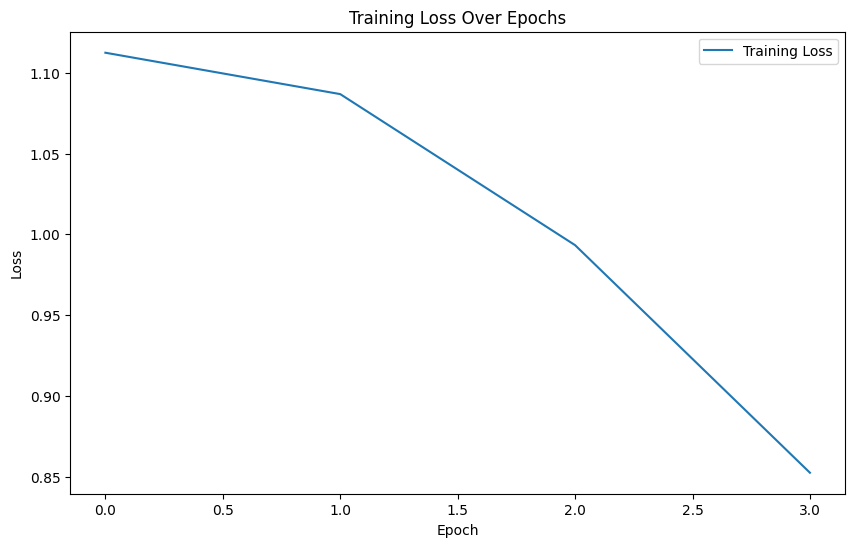

In [46]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [47]:
# Evaluation
model.eval()
test_inputs = {key: val.to(device) for key, val in test_inputs.items()}


In [48]:
with torch.no_grad():
    logits = model(**test_inputs).logits
    predictions = torch.argmax(logits, dim=1)

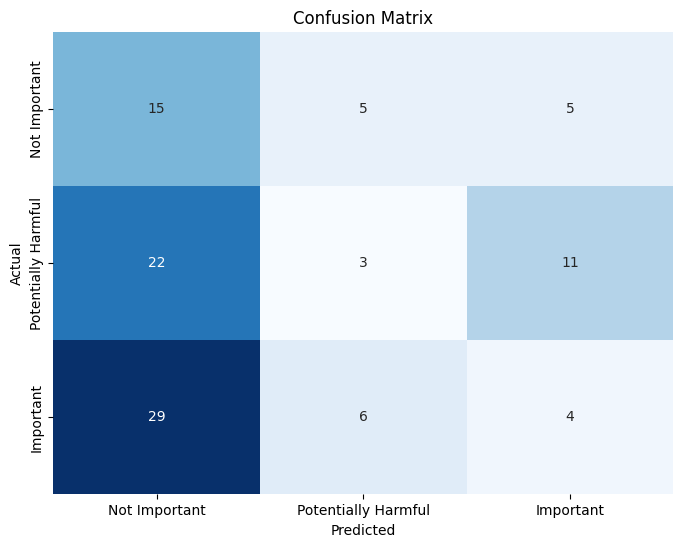

In [49]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, predictions.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Not Important", "Potentially Harmful", "Important"],
            yticklabels=["Not Important", "Potentially Harmful", "Important"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
print(classification_report(test_labels, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.23      0.60      0.33        25
           1       0.21      0.08      0.12        36
           2       0.20      0.10      0.14        39

    accuracy                           0.22       100
   macro avg       0.21      0.26      0.20       100
weighted avg       0.21      0.22      0.18       100



## Prediction

In [51]:
# input a string and return the importance
def predict(string):
    model.eval()
    with torch.no_grad():
        inputs = tokenize_sentences([string])
        inputs = {key: val.to(device) for key, val in inputs.items()}
        logits = model(**inputs).logits
        prediction = torch.argmax(logits, dim=1)
        return prediction.item()

In [52]:
predict("all is well")

1